In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
df = pd.read_csv(r"data/ny_od_main_JT00_2010.csv")

In [4]:
df.drop(columns=['createdate'], inplace=True)
df['w_tract'] = df['w_geocode'].astype(str).str[:11].astype(int)
df['h_tract'] = df['h_geocode'].astype(str).str[:11].astype(int)
df_agg = df.groupby(['w_tract', 'h_tract']).sum().reset_index().drop(columns=['w_geocode', 'h_geocode'])

Central county in Albany OMB defined MSA: Albany County, Rensselaer County, Saratoga County, Schenectady County

Tracts in Albany County, Rensselaer County, Saratoga County, Schenectady County:
* Albany county: 36001 (central county)
* Rensselaer county: 36083
* Saratoga county: 36091
* Schenectady county: 36093

Central county in Syracuse OMB defined MSA: 
* Onondaga County 36067

In [5]:
df_agg['w_county'] = df_agg['w_tract'].astype(str).str[:5].astype(int)
df_agg['h_county'] = df_agg['h_tract'].astype(str).str[:5].astype(int)
df_agg.head()

,w_tract,h_tract,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,w_county,h_county
0,36001000100,36001000100,29,5,18,6,4,10,15,5,15,9,36001,36001
1,36001000100,36001000201,11,2,7,2,3,6,2,0,8,3,36001,36001
2,36001000100,36001000202,5,1,4,0,0,5,0,0,4,1,36001,36001
3,36001000100,36001000301,3,2,1,0,0,2,1,0,1,2,36001,36001
4,36001000100,36001000302,10,3,6,1,2,7,1,1,3,6,36001,36001


In [6]:
df_agg_s = df_agg[['w_tract', 'h_tract', 'S000', 'w_county', 'h_county']]

In [7]:
total_worker_per_w_tract = df_agg_s[['w_tract', 'S000']].groupby('w_tract').sum().reset_index()
total_worker_per_h_tract = df_agg_s[['h_tract', 'S000']].groupby('h_tract').sum().reset_index()
df_agg_s1 = pd.merge(df_agg_s, total_worker_per_w_tract, left_on='w_tract', right_on='w_tract', how='inner')
df_agg_s2 = pd.merge(df_agg_s1, total_worker_per_h_tract, left_on='h_tract', right_on='h_tract', how='inner')
df_agg_s2.rename(columns={'S000_x': 'S000', 'S000_y': 'S000_w_total', 'S000': 'S000_h_total'}, inplace=True)

In [8]:
flow_matrix = df_agg_s2.pivot(index='h_tract', 
                              columns='w_tract', 
                              values='S000').fillna(0) #convert to a (#home x #work) matrix

In [9]:
tract_home_rows = flow_matrix.index 
tract_work_cols = flow_matrix.columns
flow_matrix_np = flow_matrix.astype(int).values #each row is a home, each column is a work
total_home = np.sum(flow_matrix_np, axis=1)
total_work = np.sum(flow_matrix_np, axis=0)

In [10]:
counties_home_rows = np.array(tract_home_rows.astype(str).str[:5]).astype(int)
counties_work_cols = np.array(tract_work_cols.astype(str).str[:5]).astype(int)

In [11]:
core_albany_init = np.unique(np.concatenate((tract_home_rows[counties_home_rows==36001], tract_work_cols[counties_work_cols==36001]), axis=0))
core_syracuse_init = np.unique(np.concatenate((tract_home_rows[counties_home_rows==36067], tract_work_cols[counties_work_cols==36067]), axis=0))

In [12]:
def update_core(core, flow_matrix, tract_home_rows, tract_work_cols):
    """
    This function updates the core, by adding the tracts that are not in the core but have either:
    * >25% of people who live in the tract work in the core
    * >25% of people who work in the tract live in the core
    """
    row_index_core = np.where(np.isin(tract_home_rows, core))[0]
    col_index_core = np.where(np.isin(tract_work_cols, core))[0]
    total_home = np.sum(flow_matrix, axis=1)
    total_work = np.sum(flow_matrix, axis=0)

    # find indexes of rows and columns that are not in the core but fit the definition 
    indexes_rows_add_core = np.setdiff1d(np.where((flow_matrix[:, col_index_core].sum(axis=1)/total_home) > 0.26)[0], row_index_core, assume_unique=True)
    indexes_cols_add_core = np.setdiff1d(np.where((flow_matrix[row_index_core, :].sum(axis=0)/total_work) > 0.26)[0], col_index_core, assume_unique=True)

    # adds these new tracts to the core
    new_core = np.union1d(core, np.concatenate((tract_home_rows[indexes_rows_add_core], tract_work_cols[indexes_cols_add_core]), axis=0))
    return np.unique(new_core)

In [13]:
def update_core_iterative(core, flow_matrix, tract_home_rows, tract_work_cols):
    """
    This function updates the core iteratively until no new tracts are added
    """
    core_init_length = core.shape[0]
    while True:
        new_core = update_core(core, flow_matrix, tract_home_rows, tract_work_cols)
        if np.array_equal(new_core, core):
            break
        core = new_core
    core_final_length = core.shape[0]
    print(f"Number of tracts added: {core_final_length - core_init_length}")
    return core

In [14]:
core_albany = update_core_iterative(core_albany_init, flow_matrix_np, tract_home_rows, tract_work_cols)

Number of tracts added: 299


In [15]:
core_syracuse = update_core_iterative(core_syracuse_init, flow_matrix_np, tract_home_rows, tract_work_cols)

Number of tracts added: 101


In [17]:
### BUILD COUNTY BASED MAPS
albany_countybased_omb_list_counties = [36001, 36083, 36091, 36093]
albany_countybased_omb_core = []
for county in albany_countybased_omb_list_counties:
    county_path = f"data/PVS_24_v2_cbsa_{county}.shp"
    county_df = gpd.read_file(county_path)
    albany_countybased_omb_core.append(county_df)
merged_gdf_albany_omb_core = gpd.GeoDataFrame(pd.concat([albany_countybased_omb_core[i] for i in range(len(albany_countybased_omb_list_counties))], ignore_index=True))

In [19]:
syracuse_countybased_omb_list_counties = [36067]
syracuse_countybased_omb_core = []
for county in syracuse_countybased_omb_list_counties:
    county_path = f"data/PVS_24_v2_cbsa_{county}.shp"
    county_df = gpd.read_file(county_path)
    syracuse_countybased_omb_core.append(county_df)
merged_gdf_syracuse_omb_core = gpd.GeoDataFrame(pd.concat([syracuse_countybased_omb_core[i] for i in range(len(syracuse_countybased_omb_list_counties))], ignore_index=True))

In [20]:
albany_around_counties = [36021, 36035, 36039, 36041, 36057, 36095, 36113, 36115]
albany_counties_around_omb = []
for county in albany_around_counties:
    county_path = f"data/PVS_24_v2_cbsa_{county}.shp"
    county_df = gpd.read_file(county_path)
    albany_counties_around_omb.append(county_df)
merged_gdf_albany_around_omb = gpd.GeoDataFrame(pd.concat([albany_counties_around_omb[i] for i in range(len(albany_around_counties))], ignore_index=True))

In [21]:
syracuse_around_counties = [36011, 36023, 36017, 36053, 36065, 36075]
syracuse_counties_around_omb = []
for county in syracuse_around_counties:
    county_path = f"data/PVS_24_v2_cbsa_{county}.shp"
    county_df = gpd.read_file(county_path)
    syracuse_counties_around_omb.append(county_df)
merged_gdf_syracuse_around_omb = gpd.GeoDataFrame(pd.concat([syracuse_counties_around_omb[i] for i in range(len(syracuse_around_counties))], ignore_index=True))

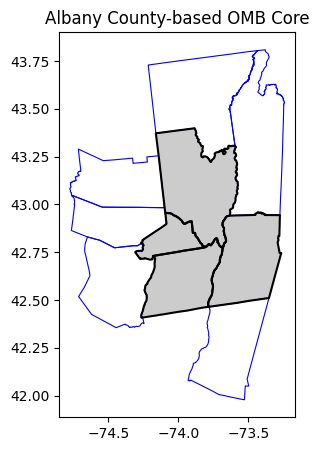

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

merged_gdf_albany_around_omb.boundary.plot(color='blue', ax=ax, linewidth=0.8)
merged_gdf_albany_omb_core.plot(color='black', alpha=0.2, ax=ax)
merged_gdf_albany_omb_core.boundary.plot(color='black', ax=ax)
ax.title.set_text('Albany County-based OMB Core')
plt.show()

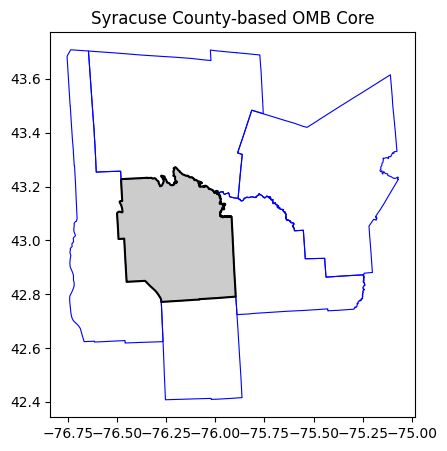

In [23]:
fig2, ax2 = plt.subplots(figsize=(5, 5))

merged_gdf_syracuse_around_omb.boundary.plot(color='blue', ax=ax2, linewidth=0.8)
merged_gdf_syracuse_omb_core.plot(color='black', alpha=0.2, ax=ax2)
merged_gdf_syracuse_omb_core.boundary.plot(color='black', ax=ax2)
ax2.title.set_text('Syracuse County-based OMB Core')
plt.show()

In [24]:
tracts_ny_path = 'partnership_shapefiles_36/PVS_24_v2_tracts2020_36.shp' 
tracts_ny_df = gpd.read_file(tracts_ny_path)

In [25]:
tracts_albany_core_gdf = tracts_ny_df.iloc[np.where(np.isin(np.array(tracts_ny_df['TRACTID']).astype(int), core_albany))[0], :]
tracts_syracuse_core_gdf = tracts_ny_df.iloc[np.where(np.isin(np.array(tracts_ny_df['TRACTID']).astype(int), core_syracuse))[0], :]

<Axes: >

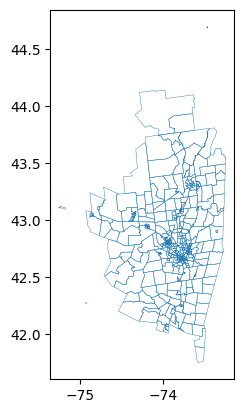

In [27]:
tracts_albany_core_gdf.boundary.plot(linewidth=0.3)

<Axes: >

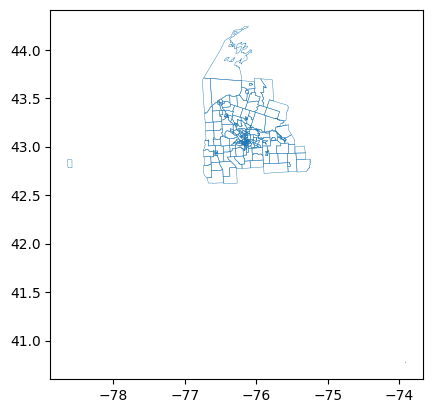

In [26]:
tracts_syracuse_core_gdf.boundary.plot(linewidth=0.3)

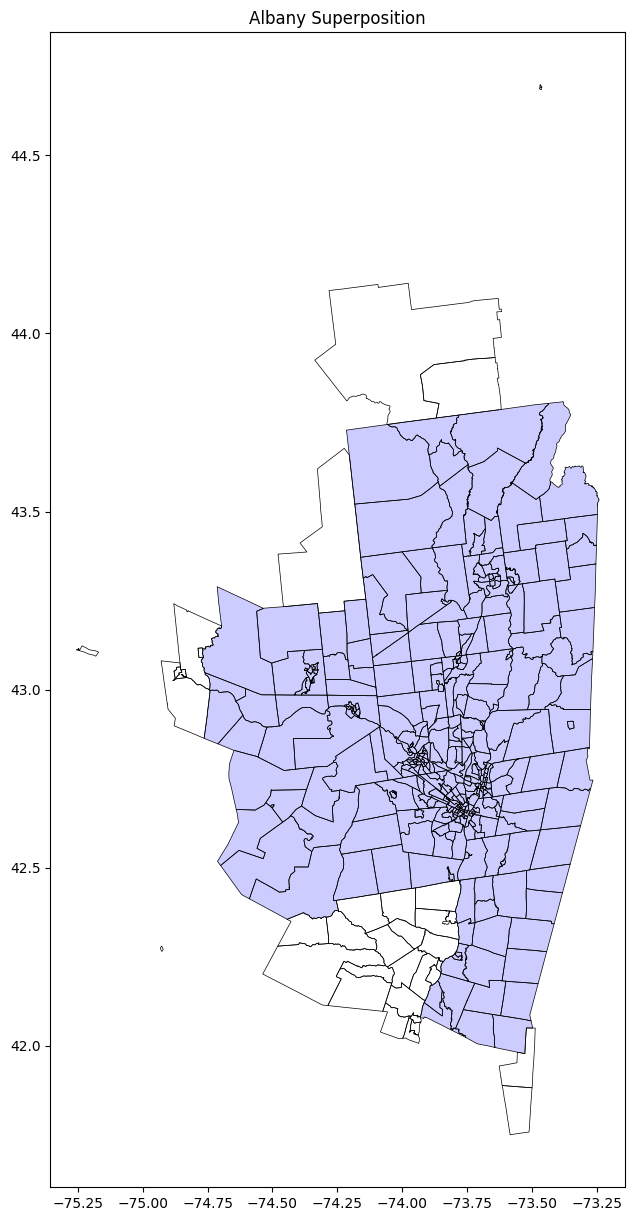

In [35]:
fig3, ax3 = plt.subplots(figsize=(15, 15))

merged_gdf_albany_around_omb.plot(color='blue', alpha=0.2, ax=ax3, linewidth=0.8)
merged_gdf_albany_omb_core.plot(color='blue', alpha=0.2, ax=ax3)
tracts_albany_core_gdf.boundary.plot(color='black', linewidth=0.5, ax=ax3)
ax3.title.set_text('Albany Superposition')
plt.show()

In [ ]:
#there are two far away outlier tracts, which I choose to remove.
buffer_distance = 0.001  # Adjust based on your CRS units
tracts_syracuse_core_gdf_filtered = tracts_syracuse_core_gdf[
    tracts_syracuse_core_gdf.geometry.apply(
        lambda g: any(g.buffer(buffer_distance).intersects(other) 
        for other in tracts_syracuse_core_gdf.geometry
        if other != g))
]

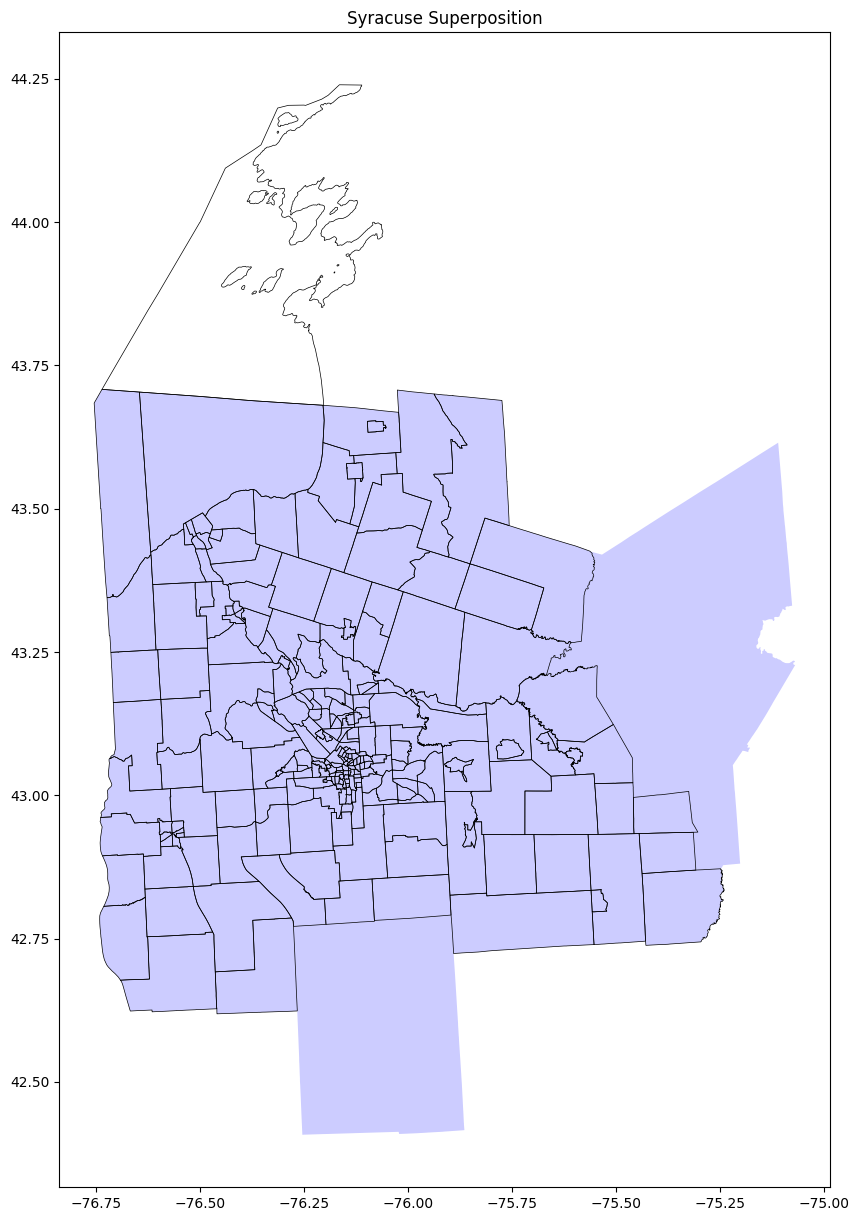

In [45]:
fig4, ax4 = plt.subplots(figsize=(15, 15))

merged_gdf_syracuse_around_omb.plot(color='blue', alpha=0.2, ax=ax4, linewidth=0.8)
merged_gdf_syracuse_omb_core.plot(color='blue', alpha=0.2, ax=ax4)
tracts_syracuse_core_gdf_filtered.boundary.plot(color='black', linewidth=0.5, ax=ax4)
ax4.title.set_text('Syracuse Superposition')
plt.show()